In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import timeit
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix)
import cv2
import shutil
from sklearn.model_selection import train_test_split

In [2]:
os.listdir('/kaggle/input/lung-cancer-dataset-1/Lung Cancer Dataset 1')

['Bengin', 'Normal', 'Malignant']

In [3]:
def get_classes(data_path, classes, data):
    print(f"----{data}----")
    images={}
    count=0

    for i in range(len(classes)):
        x=""
        if i==0:
          x="Bengin"
        elif i==1:
          x="Malignant"
        elif i==2:
          x="Normal"
        imgs=os.listdir(os.path.join(data_path, x))
        images[i]=imgs
        count+=len(imgs)

    for k, v in images.items():
        print(
            f"Grade {k}-{classes[k]}: {len(v)} images, {round((len(v)*100)/count, 2)}%"
        )

    return images

def plot_classes(dict_classes, data_path, classes, data):
    for k, v in dict_classes.items():
        print(f"{data}-{classes[k]}")
        plt.figure(figsize=(10, 25))
        x=""
        if k==0:
          x="Bengin"
        elif k==1:
          x="Malignant"
        elif k==2:
          x="Normal"
        for i in range(5):
            img_path=os.path.join(data_path, x, v[i])
            img=tf.keras.preprocessing.image.load_img(img_path)
            plt.subplot(1, 5, 1+i, xticks=[], yticks=[])
            plt.imshow(img)
            plt.title(f"{x}")
        plt.show()

In [4]:
class_names=['Bengin', 'Malignant', 'Normal']

In [5]:
base_dir="/kaggle/input/lung-cancer-dataset-1/Lung Cancer Dataset 1"

In [6]:
working_data_path = '/kaggle/working/dataset'

In [7]:
# Copy the dataset to a writable directory
if not os.path.exists(working_data_path):
    shutil.copytree(base_dir, working_data_path)

In [8]:
train_split = '/kaggle/working/dataset/train_split'  # New train data path (70%)
valid_split = '/kaggle/working/dataset/valid_split'  # New validation data path (10%)
test_split = '/kaggle/working/dataset/test_split'  # New test data path (20%)

In [9]:
# Create directories if they don't exist
os.makedirs(train_split, exist_ok=True)
os.makedirs(valid_split, exist_ok=True)
os.makedirs(test_split, exist_ok=True)

categories = os.listdir(base_dir)

In [10]:
# Split and copy data
for category in categories:
    category_path = os.path.join(base_dir, category)
    images = os.listdir(category_path)
    
    # Split the images into 70% train and 30% remaining (for test and validation)
    train_images, remaining_images = train_test_split(images, test_size=0.3, random_state=42)
    
    # Split remaining images into 2/3 test (20%) and 1/3 validation (10%)
    test_images, valid_images = train_test_split(remaining_images, test_size=1/3, random_state=42)
    
    # Create category subdirectories in the new train and valid directories
    train_category_path = os.path.join(train_split, category)
    test_category_path = os.path.join(test_split, category)
    valid_category_path = os.path.join(valid_split, category)
    os.makedirs(train_category_path, exist_ok=True)
    os.makedirs(test_category_path, exist_ok=True)
    os.makedirs(valid_category_path, exist_ok=True)
    
    # Copy images to the respective folders
    for img in train_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(train_category_path, img))
    for img in test_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(test_category_path, img))
    for img in valid_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(valid_category_path, img))

print("Data split complete!")

Data split complete!


In [11]:
train_data=get_classes(train_split, class_names, 'Train')
test_data=get_classes(test_split, class_names, 'Test')
valid_data=get_classes(valid_split, class_names, 'Valid')

----Train----
Grade 0-Bengin: 84 images, 10.95%
Grade 1-Malignant: 392 images, 51.11%
Grade 2-Normal: 291 images, 37.94%
----Test----
Grade 0-Bengin: 24 images, 10.96%
Grade 1-Malignant: 112 images, 51.14%
Grade 2-Normal: 83 images, 37.9%
----Valid----
Grade 0-Bengin: 12 images, 10.81%
Grade 1-Malignant: 57 images, 51.35%
Grade 2-Normal: 42 images, 37.84%


Train data-Bengin


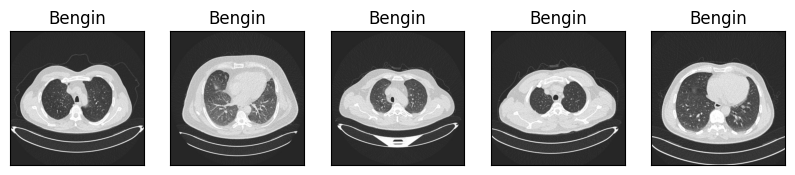

Train data-Malignant


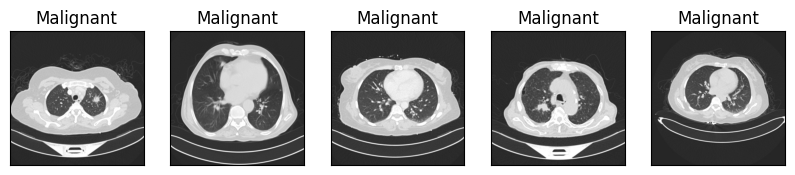

Train data-Normal


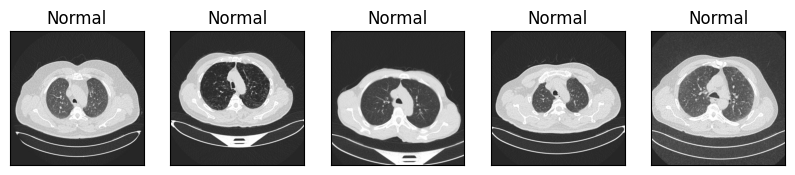

In [12]:
plot_classes(train_data, train_split, class_names, 'Train data')

In [13]:
def get_plot_loss_acc(model, model_name):
    fig=plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()

def compute_confusion_matrix(ytrue, ypred, class_names, model_name):
    cm=confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )
    cmn=cm.astype("float")/cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)

def get_evaluate(data, name, model):
    score_model=model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]: .2f}")
    print(f"{name} accuracy: {score_model[1]: .2f}")

def get_predict(data, model):
    predict_model=model.predict(data)
    return predict_model

def get_metrics(y_test, y_pred, model_name):
    acc=accuracy_score(y_test, y_pred)
    bal_acc=balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc: .2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc: .2f}")
    print("\n")

    print(classification_report(y_test, y_pred))

In [14]:
model_name="Xception"

target_size=(224, 224)
epochs=10
batch_size=256
img_shape=(224, 224, 3)

save_model_ft=os.path.join('models', f'model_{model_name}_ft.hdf5')

In [15]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
)

Found 767 images belonging to 3 classes.


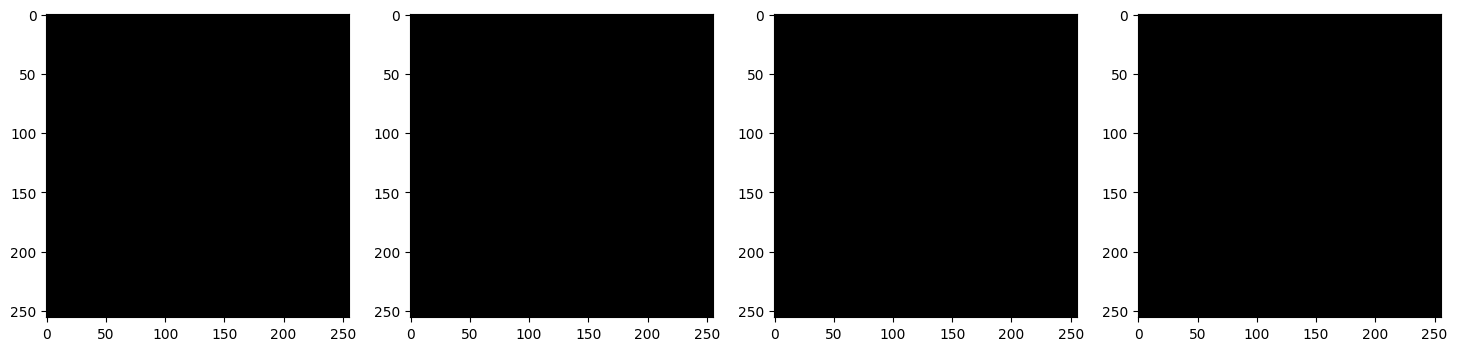

In [16]:
imagegen=aug_datagen.flow_from_directory(train_split, batch_size=1)
fig, rows=plt.subplots(nrows=1, ncols=4, figsize=(18, 18))
for row in rows:
    row.imshow(next(imagegen)[0][0].astype('uint8'))
plt.show()

In [17]:
train_generator = aug_datagen.flow_from_directory(
    train_split, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_split,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 767 images belonging to 3 classes.
Found 111 images belonging to 3 classes.


In [18]:
y_train = train_generator.labels
y_val = valid_generator.labels

In [19]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train: ", dict(zip(unique, counts)))

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

Train:  {0: 84, 1: 392, 2: 291}
{0: 3.0436507936507935, 1: 0.6522108843537415, 2: 0.8785796105383734}


In [20]:
classes = np.unique(y_train)

# Callbacks
early = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0.01, patience=8,
            restore_best_weights=True
        )
plateau = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='loss', factor=0.1, min_delta=0.01,
                min_lr=1e-10, patience=4, mode='auto'
            )

In [21]:
model = tf.keras.applications.Xception(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

In [22]:
m=model.output

In [23]:
m = tf.keras.layers.GlobalAveragePooling2D()(m)
m = tf.keras.layers.Dropout(0.2)(m)

In [24]:
predictions = tf.keras.layers.Dense(3, activation='softmax')(m)

In [25]:
model_ft = tf.keras.models.Model(inputs=model.input, outputs=predictions)
model_ft.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 20,867,627 (79.60 MB)

 Trainable params: 20,813,099 (79.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [26]:
model_ft.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [27]:
start_ft = timeit.default_timer()

history = model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_ft = timeit.default_timer()

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728463611.919409     277 service.cc:145] XLA service 0x7e69e802ef90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728463611.919459     277 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728463611.919465     277 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728463643.007706     277 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.6684 - loss: 0.7561 - val_accuracy: 0.8739 - val_loss: 0.5561
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 73s 457ms/step - accuracy: 0.6083 - loss: 0.6851 - val_accuracy: 0.6216 - val_loss: 1.3475
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 451ms/step - accuracy: 0.7966 - loss: 0.4906 - val_accuracy: 0.8559 - val_loss: 0.7918
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 464ms/step - accuracy: 0.8544 - loss: 0.4118 - val_accuracy: 0.5856 - val_loss: 1.2394
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 450ms/step - accuracy: 0.8824 - loss: 0.4108 - val_accuracy: 0.5405 - val_loss: 5.5273
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 462ms/step - accuracy: 0.8934 - loss: 0.3448 - val_accuracy: 0.1081 - val_loss: 251.6094
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 453ms/step - accuracy: 0.8841 - loss: 0.3250 - val_accuracy: 0.1261 - val_loss: 17.7537
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 451ms/step - accuracy: 0.9460 - loss: 0.2002 - val_accuracy: 0.65

In [28]:
execution_time_ft = (stop_ft - start_ft) / 60
print(
    f"Model {model_name} fine tuning executed in {execution_time_ft:.2f} minutes"
)

Model Xception fine tuning executed in 4.91 minutes


In [29]:
model.save('/kaggle/working/Xception.h5')

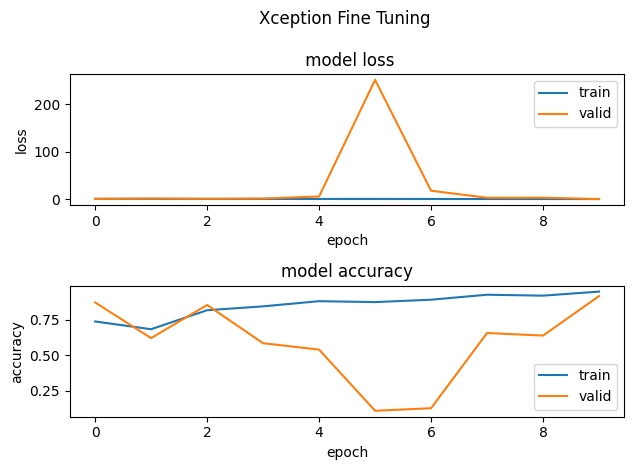

In [30]:
get_plot_loss_acc(model_ft, f"{model_name} Fine Tuning")

In [31]:
get_evaluate(train_generator, "Train", model_ft)

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 490ms/step - accuracy: 0.8407 - loss: 0.7767
Train loss:  0.73
Train accuracy:  0.86


In [32]:
get_evaluate(valid_generator, "Valid", model_ft)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9457 - loss: 0.1356
Valid loss:  0.21
Valid accuracy:  0.92


In [33]:
predict_model_ft = get_predict(valid_generator, model_ft)

get_metrics(
    valid_generator.labels,
    y_pred=np.argmax(predict_model_ft, axis=1),
    model_name=model_name,
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 805ms/step
Accuracy Score - Xception:  0.92
Balanced Accuracy Score - Xception:  0.91


              precision    recall  f1-score   support

           0       0.69      0.92      0.79        12
           1       0.93      1.00      0.97        57
           2       1.00      0.81      0.89        42

    accuracy                           0.92       111
   macro avg       0.87      0.91      0.88       111
weighted avg       0.93      0.92      0.92       111



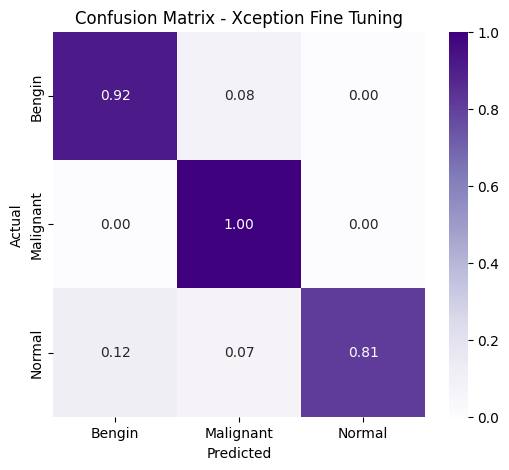

In [34]:
compute_confusion_matrix(
    valid_generator, predict_model_ft, class_names, f"{model_name} Fine Tuning"
)

In [35]:
test_generator = noaug_datagen.flow_from_directory(
    test_split,
    batch_size=batch_size,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 219 images belonging to 3 classes.


In [36]:
Xception = model_ft

In [37]:
predictions_xception = Xception.predict(test_generator)
score_xception = Xception.evaluate(test_generator, verbose=1)
print('Test loss:', score_xception[0])
print('Test acc:', score_xception[1])

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-09 08:51:46.992339: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng30{k2=2,k4=2,k5=0,k6=0,k7=0} for conv (f32[219,64,109,109]{3,2,1,0}, u8[0]{0}) custom-call(f32[219,64,109,109]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-10-09 08:51:47.534943: E extern

1/1 ━━━━━━━━━━━━━━━━━━━━ 61s 61s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9132 - loss: 0.1852
Test loss: 0.1852485090494156
Test acc: 0.913241982460022


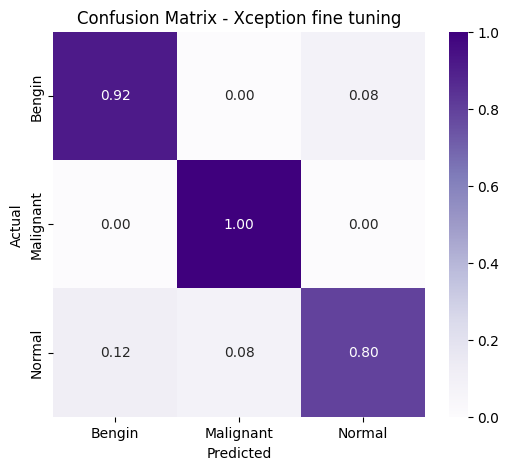

In [38]:
compute_confusion_matrix(
    test_generator,
    predictions_xception,
    class_names,
    f"{model_name} fine tuning",
)

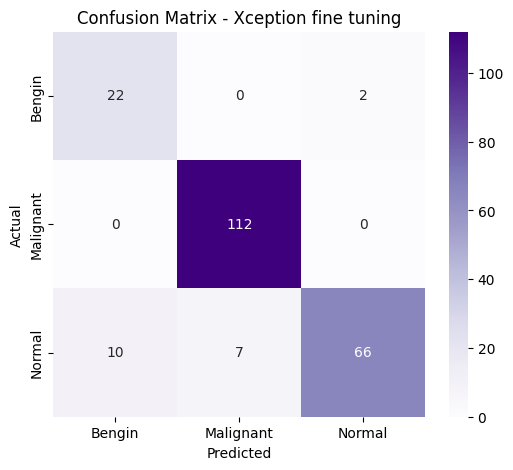

In [39]:
def count_confusion_matrix(ytrue, ypred, class_names, model_name):
    cm=confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )
    cmn=cm.astype("int")
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".0f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)
    
count_confusion_matrix(
    test_generator,
    predictions_xception,
    class_names,
    f"{model_name} fine tuning",
)

In [41]:
results = get_predict(test_generator, Xception)

get_metrics(
    test_generator.labels,
    y_pred=np.argmax(results, axis=1),
    model_name=model_name,
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
Accuracy Score - Xception:  0.91
Balanced Accuracy Score - Xception:  0.90


              precision    recall  f1-score   support

           0       0.69      0.92      0.79        24
           1       0.94      1.00      0.97       112
           2       0.97      0.80      0.87        83

    accuracy                           0.91       219
   macro avg       0.87      0.90      0.88       219
weighted avg       0.92      0.91      0.91       219

